In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import InputLayer, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

2025-05-02 04:05:41.049282: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746158741.246763      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746158741.298997      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
from sklearn.utils import resample
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model

# Data Exploration

In [3]:
data_path = os.path.join('/kaggle/input/covidx-cxr2')
train_data_path = os.path.join(data_path, 'train')
test_data_path = os.path.join(data_path,'test')
train_df = pd.read_csv(os.path.join(data_path, 'train.txt'), sep=" ", index_col=None, header=None)
test_df = pd.read_csv(os.path.join(data_path, 'test.txt'), sep=" ", index_col=None, header=None)

In [4]:
val_data_path = os.path.join(data_path,'val')

val_df = pd.read_csv(os.path.join(data_path, 'val.txt'), sep=" ", index_col=None, header=None)


In [5]:
val_df.head()

,0,1,2,3
0,ANON196,CR.1.2.840.113564.1722810170.20200318082923328...,positive,actmed
1,ANON170,CR.1.2.840.113564.1722810170.20200320011259312...,positive,actmed
2,S03044,sub-S03044_ses-E06138_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
3,S03044,sub-S03044_ses-E07712_run-1_bp-chest_vp-ap_cr-...,positive,bimcv
4,S03044,sub-S03044_ses-E06790_run-1_bp-chest_vp-pa_dx-...,positive,bimcv


In [6]:
train_df.head()

,0,1,2,3
0,379,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative,cohen
1,379,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative,cohen
2,380,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative,cohen
3,380,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative,cohen
4,382,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative,cohen


In [7]:
train_df.drop(columns = [0,3], axis=1, inplace=True)
test_df.drop(columns = [0,3], axis=1, inplace=True)
val_df.drop(columns = [0,3], axis=1, inplace=True)

In [8]:
train_df = train_df.rename(columns = {1:'image_name', 2:'diagnosis'})
test_df = test_df.rename(columns = {1:'image_name', 2:'diagnosis'})
val_df=val_df.rename(columns = {1:'image_name', 2:'diagnosis'})


In [9]:
train_df.head()

,image_name,diagnosis
0,1e64990d1b40c1758a2aaa9c7f7a85_jumbo.jpeg,negative
1,7223b8ad031187d9a142d7f7ca02c9_jumbo.jpeg,negative
2,3392dc7d262e28423caca517f98c2e_jumbo.jpeg,negative
3,ec3a480c0926ded74429df416cfb05_jumbo.jpeg,negative
4,a72aeb349a63c79ed24e473c434efe_jumbo.jpg,negative


In [10]:
train_df.diagnosis.value_counts()

diagnosis
positive    57199
negative    10664
Name: count, dtype: int64

In [11]:
val_df.diagnosis.value_counts()

diagnosis
positive    4241
negative    4232
Name: count, dtype: int64

In [12]:
train_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [13]:
train_df.duplicated().sum()

0

In [14]:
val_df.isnull().sum()

image_name    0
diagnosis     0
dtype: int64

In [15]:
val_df.duplicated().sum()

0

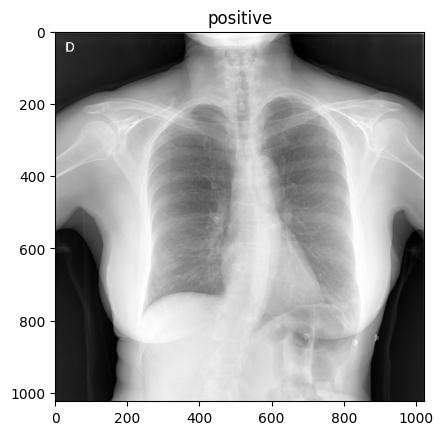

(1024, 1024, 3)

In [16]:
rand_indx = np.random.randint(0,len(train_df),1)[0]
img = cv2.imread(os.path.join(train_data_path, train_df.image_name[rand_indx]))
plt.imshow(img/255)
plt.title(train_df.diagnosis[rand_indx])
plt.show()
img.shape

In [17]:
from sklearn.model_selection import train_test_split

In [18]:
train_df, df_test = train_test_split(train_df, test_size=0.2, stratify=train_df['diagnosis'], random_state=42)

In [19]:
df_majority = train_df[train_df['diagnosis'] == 'positive']
df_minority = train_df[train_df['diagnosis'] == 'negative']

df_minority_upsampled = resample(df_minority, 
                                 replace=True,     
                                 n_samples=len(df_majority), 
                                 random_state=42)

train_df = pd.concat([df_majority, df_minority_upsampled])
train_df = train_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [20]:
train_df.diagnosis.value_counts()

diagnosis
positive    45759
negative    45759
Name: count, dtype: int64

In [21]:
df_test.diagnosis.value_counts()

diagnosis
positive    11440
negative     2133
Name: count, dtype: int64

In [22]:
def custom_preprocess(img):
    img = img.astype(np.uint8)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    lab = cv2.merge((cl, a, b))
    img = cv2.cvtColor(lab, cv2.COLOR_LAB2RGB)

    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 30, 255, cv2.THRESH_BINARY)
    mask = cv2.medianBlur(mask, 5)
    mask = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    img = cv2.bitwise_and(img, mask)

    return img.astype(np.float32) / 255.0


In [23]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

train_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess,
    rotation_range=15, zoom_range=0.1, horizontal_flip=True,
    width_shift_range=0.05, height_shift_range=0.05
).flow_from_dataframe(
    dataframe=train_df, directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=True
)

val_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=val_df, directory=val_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 91518 validated image filenames belonging to 2 classes.
Found 8473 validated image filenames belonging to 2 classes.


In [24]:
test_datagen = ImageDataGenerator(preprocessing_function=custom_preprocess)

test_gen = test_datagen.flow_from_dataframe(
    dataframe=df_test,
    directory=train_data_path,
    x_col='image_name',
    y_col='diagnosis',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)


Found 13573 validated image filenames belonging to 2 classes.


# **DenseNet121 Model**

In [25]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

In [26]:
base_model = DenseNet121(input_shape=(224, 224, 3), include_top=False, weights='imagenet')
base_model.trainable = False  

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)  

model = Model(inputs=base_model.input, outputs=output)

I0000 00:00:1746159098.726437      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [28]:
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

EPOCHS = 10
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=[early_stop]
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1746159133.412818      96 service.cc:148] XLA service 0x78dfb008a1b0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1746159133.413626      96 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1746159136.241135      96 cuda_dnn.cc:529] Loaded cuDNN version 90300


   2/2860 ━━━━━━━━━━━━━━━━━━━━ 2:32 53ms/step - accuracy: 0.3125 - loss: 1.3617   

I0000 00:00:1746159146.445099      96 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2710s 935ms/step - accuracy: 0.5931 - loss: 0.7304 - val_accuracy: 0.8322 - val_loss: 0.4399
Epoch 2/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2439s 851ms/step - accuracy: 0.7338 - loss: 0.5303 - val_accuracy: 0.8502 - val_loss: 0.4133
Epoch 3/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2251s 785ms/step - accuracy: 0.7623 - loss: 0.4955 - val_accuracy: 0.8553 - val_loss: 0.4019
Epoch 4/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2372s 828ms/step - accuracy: 0.7676 - loss: 0.4863 - val_accuracy: 0.8571 - val_loss: 0.3985
Epoch 5/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2286s 798ms/step - accuracy: 0.7719 - loss: 0.4833 - val_accuracy: 0.8601 - val_loss: 0.3952
Epoch 6/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2289s 798ms/step - accuracy: 0.7734 - loss: 0.4832 - val_accuracy: 0.8571 - val_loss: 0.3962
Epoch 7/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2331s 813ms/step - accuracy: 0.7735 - loss: 0.4783 - val_accuracy: 0.8547 - val_loss: 0.3993
Epoch 8/10
2860/2860 ━━━━━━━━━━━━━━━━━━━━ 2316s 808ms/step - accur

In [29]:
test_gen = ImageDataGenerator(
    preprocessing_function=custom_preprocess
).flow_from_dataframe(
    dataframe=df_test, 
    directory=train_data_path,
    x_col='image_name', y_col='diagnosis',
    target_size=IMG_SIZE, batch_size=BATCH_SIZE,
    class_mode='binary', shuffle=False
)


Found 13573 validated image filenames belonging to 2 classes.


In [30]:
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
print(f"Train Accuracy: {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")

Train Accuracy: 0.7770
Validation Accuracy: 0.8604


In [31]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"Test Accuracy: {test_acc:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


425/425 ━━━━━━━━━━━━━━━━━━━━ 281s 661ms/step - accuracy: 0.8736 - loss: 0.3393
Test Accuracy: 0.8748


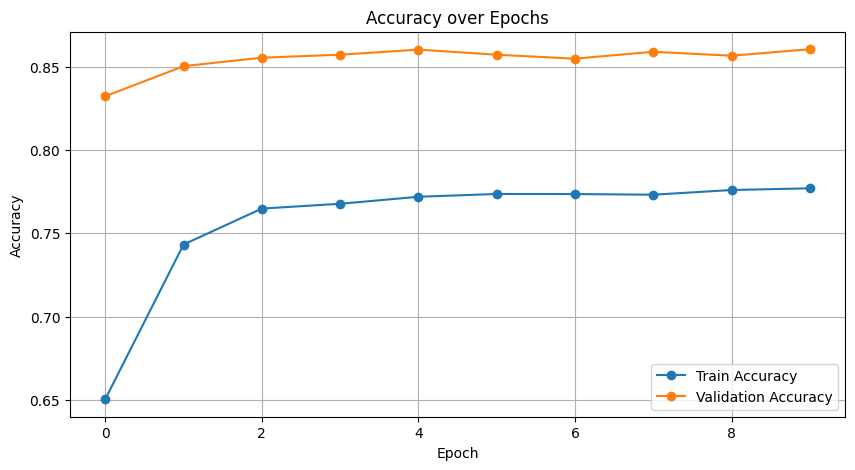

In [32]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Train Accuracy', marker='o')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', marker='o')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

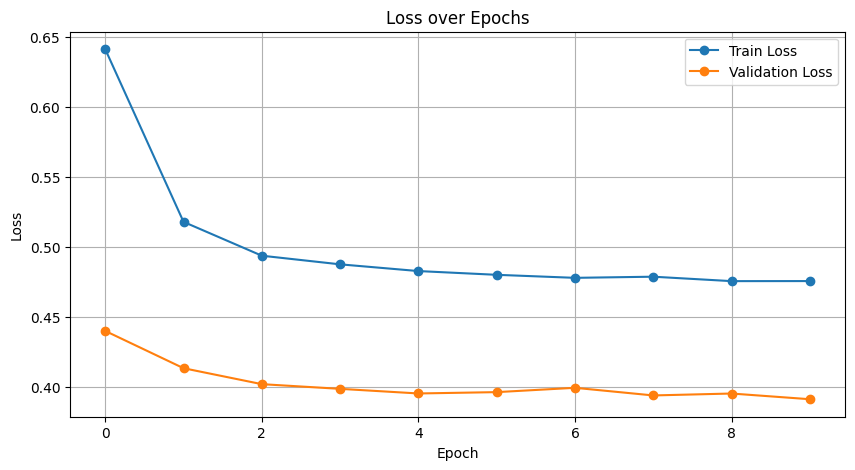

In [33]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Train Loss', marker='o')
plt.plot(history.history['val_loss'], label='Validation Loss', marker='o')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [34]:
y_pred_probs = model.predict(test_gen)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()
y_true = test_gen.classes

425/425 ━━━━━━━━━━━━━━━━━━━━ 260s 583ms/step


In [35]:
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=test_gen.class_indices.keys()))


Classification Report:
              precision    recall  f1-score   support

    negative       0.57      0.80      0.67      2133
    positive       0.96      0.89      0.92     11440

    accuracy                           0.87     13573
   macro avg       0.77      0.84      0.80     13573
weighted avg       0.90      0.87      0.88     13573



# Explainability

In [37]:
import seaborn as sns

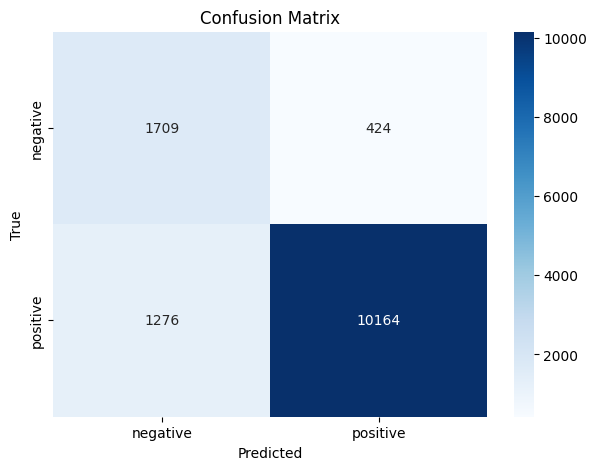

In [38]:
conf_matrix = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=test_gen.class_indices.keys(), yticklabels=test_gen.class_indices.keys())
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

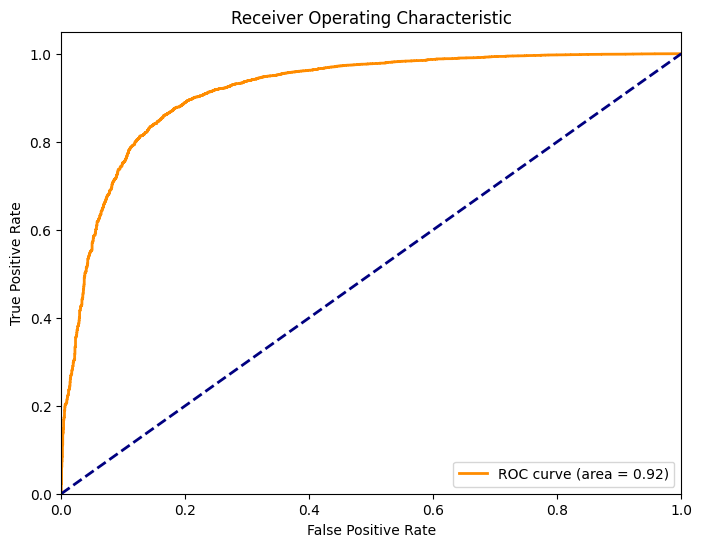

In [69]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_true,y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

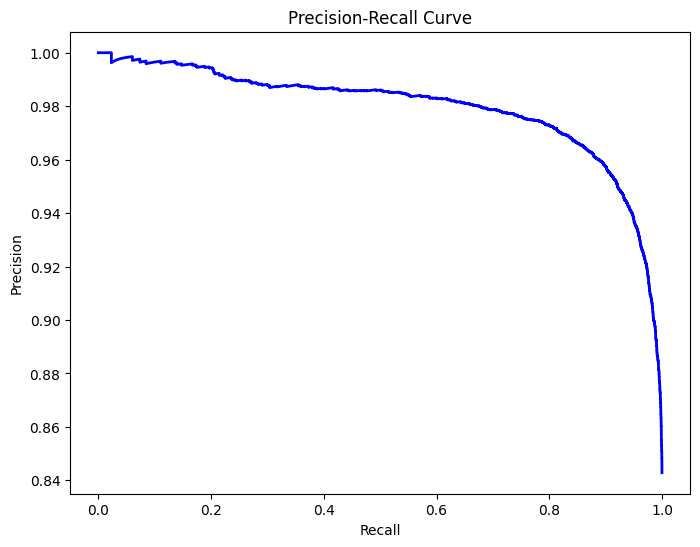

In [70]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_true,y_pred_probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='b', lw=2)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()


**Lime**

In [49]:
from lime import lime_image
from skimage.segmentation import mark_boundaries
import torch
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import Image

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━

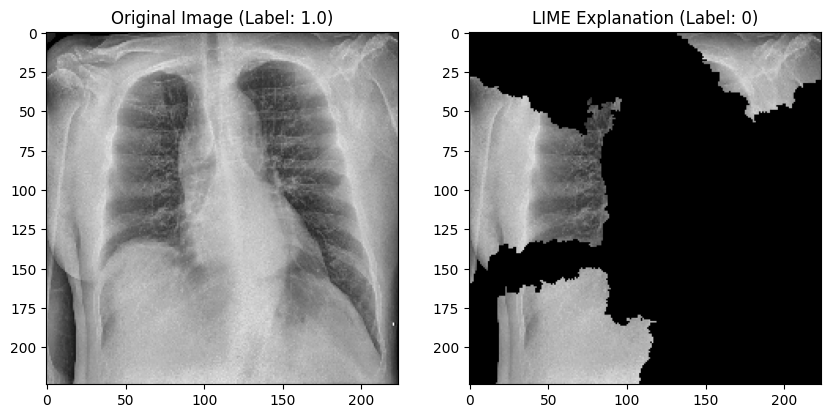

In [53]:
explainer = lime_image.LimeImageExplainer()

def predict_fn(images):
    images = np.array(images)
    return model.predict(images)

idx = 0  
img = test_gen[idx][0]  
img_class = test_gen[idx][1]  

explanation = explainer.explain_instance(img[0], predict_fn, top_labels=2, hide_color=0, num_samples=1000)

temp, mask = explanation.get_image_and_mask(
    explanation.top_labels[0], 
    positive_only=True, 
    num_features=5, 
    hide_rest=True
)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[0])
plt.title(f"Original Image (Label: {img_class[0]})")

plt.subplot(1, 2, 2)
plt.imshow(temp)
plt.title(f"LIME Explanation (Label: {explanation.top_labels[0]})")
plt.show()

**Grad-CAM**

In [62]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        loss = predictions[:, 0] 

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap + 1e-10)
    return heatmap.numpy()

def overlay_heatmap(heatmap, img, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap_color = cv2.applyColorMap(heatmap, colormap)
    overlay = cv2.addWeighted(img, 1 - alpha, heatmap_color, alpha, 0)
    return overlay

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (224, 224))
    img = img / 255.0
    return np.expand_dims(img, axis=0)

def run_gradcam(img_path, model, last_conv_layer_name):
    img_array = preprocess_image(img_path)

    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

    original_img = cv2.imread(img_path)
    original_img = cv2.resize(original_img, (224, 224))
    original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

    overlay = overlay_heatmap(heatmap, original_img)

    plt.figure(figsize=(6, 6))
    plt.imshow(overlay)
    plt.axis('off')
    plt.title("Grad-CAM Heatmap")
    plt.show()




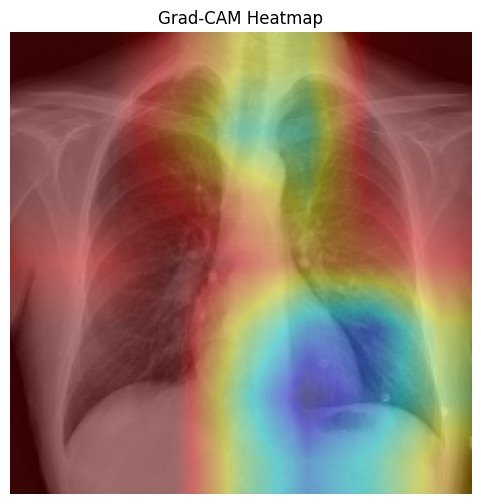

In [66]:
run_gradcam("/kaggle/input/covidx-cxr2/train/000001-3.jpg", model, last_conv_layer_name='conv5_block16_2_conv')

**ICE**

In [72]:
x = np.expand_dims(img, axis=0)

col = 100  
intensities = np.linspace(0, 1, 50)
predictions = []

for val in intensities:
    x_mod = x.copy()
    x_mod[0, :, col, 0] = val  
    pred = model.predict(x_mod, verbose=0)[0][0]
    predictions.append(pred)



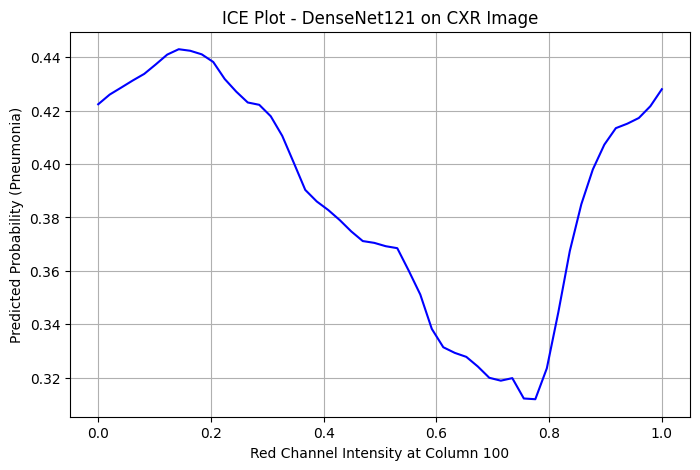

In [73]:
plt.figure(figsize=(8, 5))
plt.plot(intensities, predictions, color='blue')
plt.xlabel("Red Channel Intensity at Column {}".format(col))
plt.ylabel("Predicted Probability (Pneumonia)")
plt.title("ICE Plot - DenseNet121 on CXR Image")
plt.grid(True)
plt.show()
